In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

### This notebook applies some of our initial XAI techniques to LSTM model predictions for DO in the DRB
Start by defining a bunch of functions that we'll need

In [2]:
## The model itself

class LSTMModel(tf.keras.Model):
    def __init__(
        self, hidden_size, num_tasks, recurrent_dropout=0, dropout=0,
    ):
        """
        :param hidden_size: [int] the number of hidden units
        :param num_tasks: [int] number of outputs to predict 
        :param recurrent_dropout: [float] value between 0 and 1 for the
        probability of a recurrent element to be zero
        :param dropout: [float] value between 0 and 1 for the probability of an
        input element to be zero
        """
        super().__init__()
        self.rnn_layer = layers.LSTM(
            hidden_size,
            return_sequences=True,
            recurrent_dropout=recurrent_dropout,
            dropout=dropout,
        )
        self.dense = layers.Dense(num_tasks)

    @tf.function
    def call(self, inputs):
        h = self.rnn_layer(inputs)
        prediction = self.dense(h)
        return prediction

## Our EG Function
def expected_gradients_tf(x, x_set, model, n_samples, temporal_focus=None,task_focus=1):

    n_series = x_set.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]
    
    for k in range(n_samples):
        # SAMPLE A SERIES FROM OUR DATA
        rand_seq = np.random.choice(n_series) # rand_time may be more accurate
        baseline_x = x_set[rand_seq]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        #print(x_diff)
        curr_x = baseline_x + scale*x_diff
        curr_x = tf.convert_to_tensor(curr_x)
        with tf.GradientTape() as gtape:
            gtape.watch(curr_x)
            if temporal_focus == None:
                y = model(curr_x)[:,:,task_focus]
            else:
                y=model(curr_x)[:,temporal_focus,task_focus]

        gradients = gtape.gradient(y, curr_x, tf.ones_like(y))
        #print(gradients)
        if k == 0:
            expected_gradients = x_diff*gradients * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients) * 1/n_samples)
    return(expected_gradients.numpy())

## Masked rmse for permutation feature importance
def rmse_masked(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    num_y_true = tf.cast(
        tf.math.count_nonzero(~tf.math.is_nan(y_true)), tf.float32
    )
    if num_y_true > 0:
        zero_or_error = tf.where(
            tf.math.is_nan(y_true), tf.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = tf.reduce_sum(tf.square(zero_or_error))
        rmse_loss = tf.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

## Permutation feature importance itself
def calc_permutation_feature_importance(model, data_in, y, scale_std,task=1):
    original_y_hat = model.predict(data_in)
    rmse_original = rmse_masked(y,original_y_hat)
    fi_ls=[]
    for var in range(len(x_vars)):
        var_range = np.quantile(data_in[:,:,var].flatten(),[.1,.9])
        x_hypothesis = data_in.copy()
        x_hypothesis[:, :, var] = (var_range[0]-var_range[1])*np.random.uniform(x_hypothesis[:, :, var])+var_range[1]   
        #Make random distribution within the range of the target variable
        y_hypothesis = model.predict(x_hypothesis)
        print(y_hypothesis.shape)
        rmse_hypothesis = rmse_masked(y[:,:,task],y_hypothesis[:,:,task])
        delta_rmse = rmse_hypothesis-rmse_original
        fi_ls.append(delta_rmse)
    return np.array(fi_ls)

### Load in the model and the data

In [3]:
weights_file = '../test_data/DO_LSTM/train_weights/'
prepped_file = '../test_data/DO_LSTM/prepped.npz'

prepped = np.load(prepped_file, allow_pickle=True)
x_vars = prepped['x_vars']
num_vars = len(x_vars)
num_tasks = prepped['y_obs_trn'].shape[-1]

### Load our model
model = LSTMModel(10,num_tasks,.2,.2)
model.load_weights(weights_file)

# Double check the weights maps correctly
mod_test = model.predict(np.expand_dims(prepped['x_trn'][1,...],axis=0))
model.summary()
mod_test.shape

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  960       
_________________________________________________________________
dense (Dense)                multiple                  33        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


(1, 365, 3)

In [4]:
### For now we're just going to concatenate all our data,
x_full = np.concatenate((prepped['x_trn'],prepped['x_val'],prepped['x_tst']))
y_full = np.concatenate((prepped['y_obs_trn'],prepped['y_obs_val'],prepped['y_obs_tst']))
times_full = np.concatenate((prepped['times_trn'],prepped['times_val'],prepped['times_tst']))
ids_full = np.concatenate((prepped['ids_trn'],prepped['ids_val'],prepped['ids_tst']))

prepped['x_trn'].shape, ids_full.shape, y_full.shape

((408, 365, 13), (468, 365, 1), (468, 365, 3))

### Start with calculating global feature importance

In [7]:
feat_imp = calc_permutation_feature_importance(model, x_full, y_full, prepped['y_std'],task=2)

(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)
(468, 365, 3)


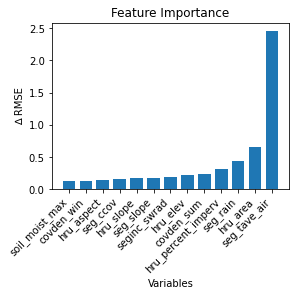

In [8]:
ordered_importance_of_vars = np.argsort(feat_imp)

### Plot up the results in order of importance
plt.figure(figsize=(4,4),constrained_layout=True) 
plt.bar(np.linspace(0,len(feat_imp),len(feat_imp)),feat_imp[ordered_importance_of_vars])
plt.xticks(np.linspace(0,len(feat_imp),len(feat_imp)), labels = x_vars[ordered_importance_of_vars], rotation = 45,ha='right')
plt.title('Feature Importance')
plt.ylabel('∆ RMSE')
plt.xlabel("Variables");

### Lets take a look at EG vals for a specific reach of interest

In [8]:
## Helper function for pulling specific segments
def pull_target_seg(x, y, times, ids, segment):    
    target_indices=np.where(ids[:,0,0]==segment)
    x_target = x[target_indices,:,:][0]
    y_target = y[target_indices,:,:][0]
    times_target = times[target_indices,:,:][0]
    ids_target = ids[target_indices,:,:][0]
    return x_target, y_target, times_target, ids_target

target_x, target_y, target_times, target_ids = pull_target_seg(x_full, y_full, times_full, ids_full, '01473500')
target_x.shape, target_y.shape

((39, 365, 13), (39, 365, 3))

#### Pull a sequence with lots of observations so we can see actual DO levels that go along with the preds

In [11]:
target_sequence = np.count_nonzero(~np.isnan(target_y[:,:,1].reshape(target_y.shape[0],365)),axis=1).argmax()
dates = target_times[target_sequence].flatten()

### Start by looking at the EGs at roughly ~monthly intervals throughout the year

In [17]:
egs = []
for i in range(30,365,30):
    egs_step = expected_gradients_tf(np.expand_dims(target_x[0],axis=0), x_full, model, n_samples=200,temporal_focus=i)
    egs.append(egs_step)

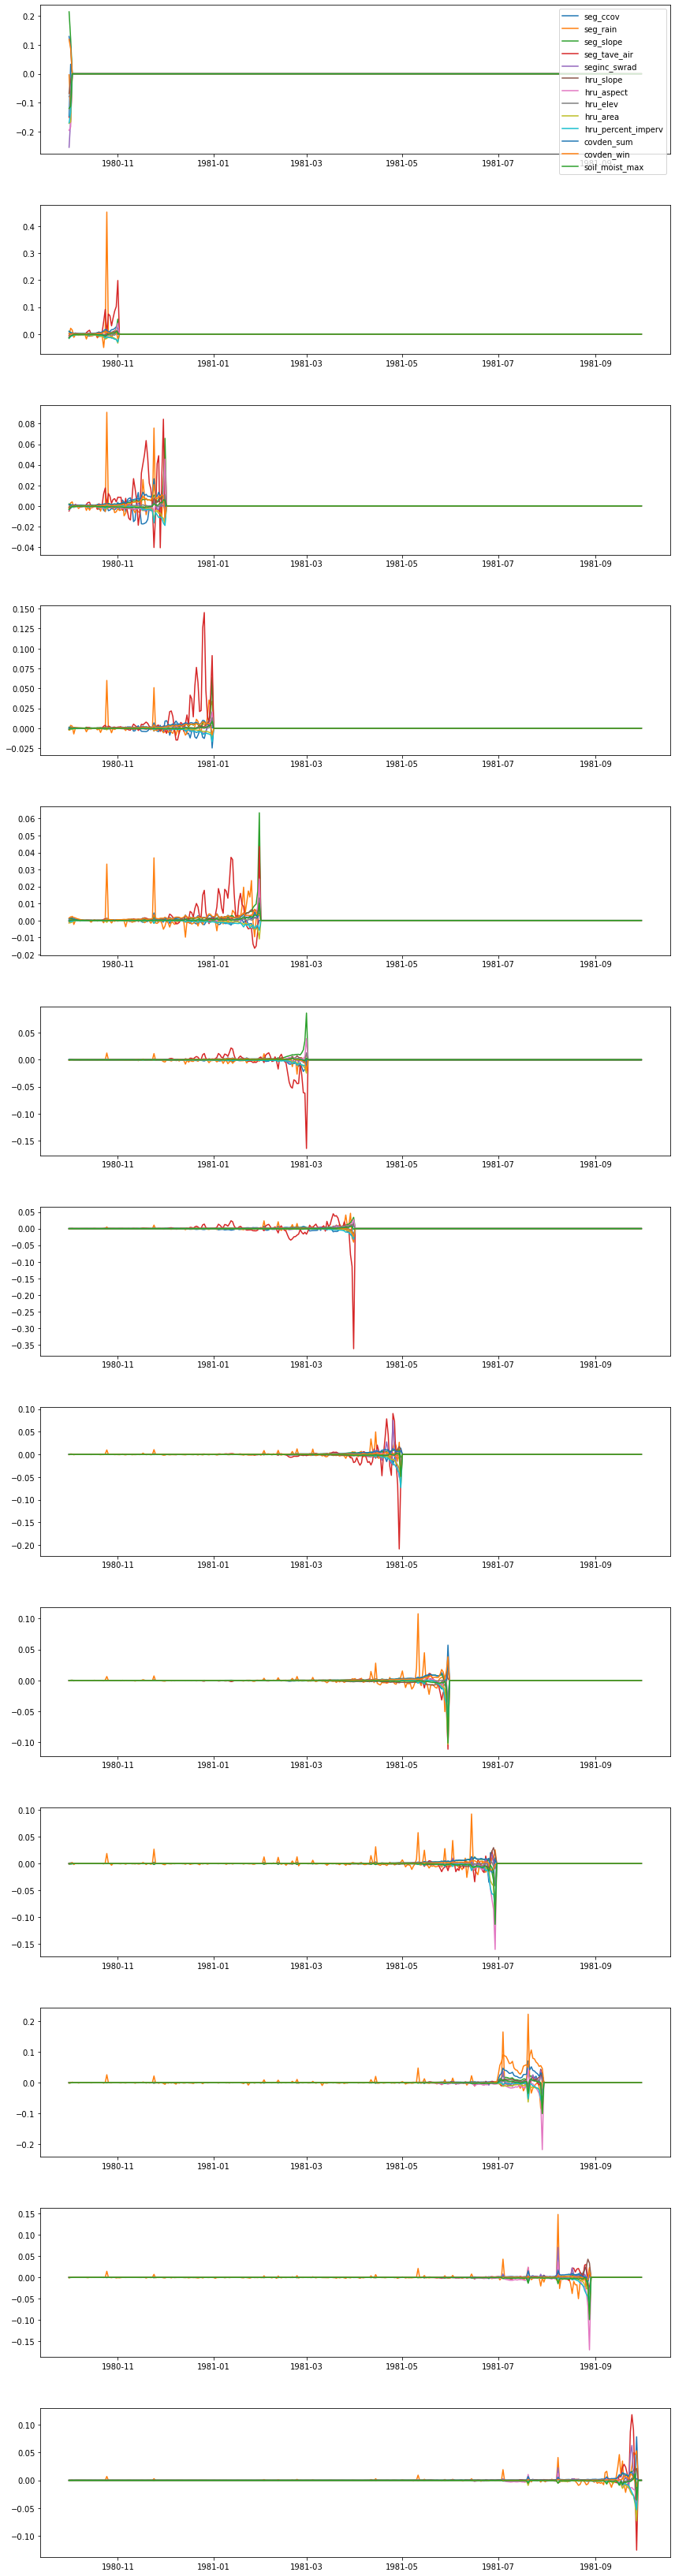

In [52]:
num_plots = len(egs)
fig, axes = plt.subplots(nrows=num_plots,figsize=(12,3.5*num_plots), tight_layout=True)
for j in range(num_plots):
    for i in range(num_vars):
        axes[j].plot(dates,egs[j][0,:, i], label = x_vars[i])
axes[0].legend(loc = 'upper right')

Some interesting stuff right off the bat.  It looks like, at least for this sequence, the "memory" of the model is longest during the winter.  Also, throughout the year, it looks like the model is remembering precip beyond 30 days prior to the the prediction (which isn't the case for the temperature modelling). Still, for most times of year, there's fairly little influence beyond ~2 months back.

#### Look at EGs with regard to all predictions to get a general sense for the order of magnitude of attribution for different vars and how they correspond with the actual time series

In [12]:
%%time
EG_vals = expected_gradients_tf(np.expand_dims(target_x[0],axis=0), x_full, model, n_samples=200)

CPU times: user 1min 35s, sys: 14.9 s, total: 1min 50s
Wall time: 34.7 s


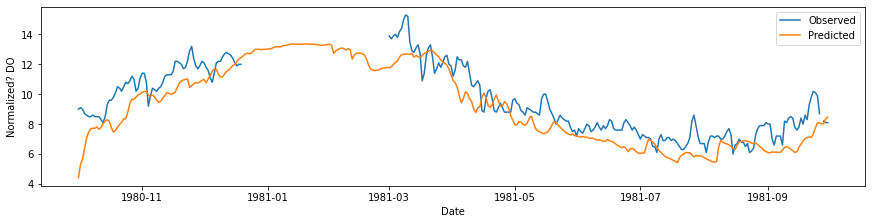

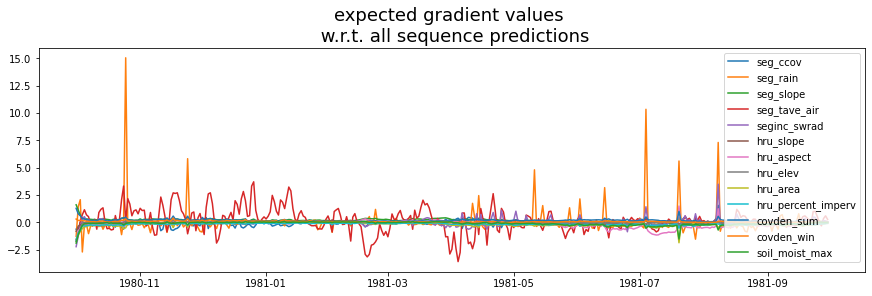

In [53]:
preds = model.predict(np.expand_dims(target_x[0],axis=0))
plt.figure(figsize=(12,3), constrained_layout=True)
plt.plot(dates,target_y[target_sequence,:,1].flatten(),label='Observed')
plt.plot(dates,preds[:,:,1].flatten(),label="Predicted")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Normalized? DO')

dates = target_times[0].flatten()
plt.figure(figsize = (12, 4),constrained_layout=True)
for i in range(num_vars):
    plt.plot(dates,EG_vals[0, :, i], label=x_vars[i])
plt.legend(loc='upper right')
plt.title('expected gradient values \n w.r.t. all sequence predictions',
          fontsize = 18);

Looks like air temp is fairly influential throughout, and that precip is sporadically very influential as we'd expect. Below we can look at each one individually to get a sense of how it changes throughout the year. Remember that for everything except precip, the model isn't using anything more than ~two months prior to the target date.  That means below, any attribution is likely influencing preds within ~two months of the date on the x axis.

Text(0, 0.5, 'Expected Gradients')

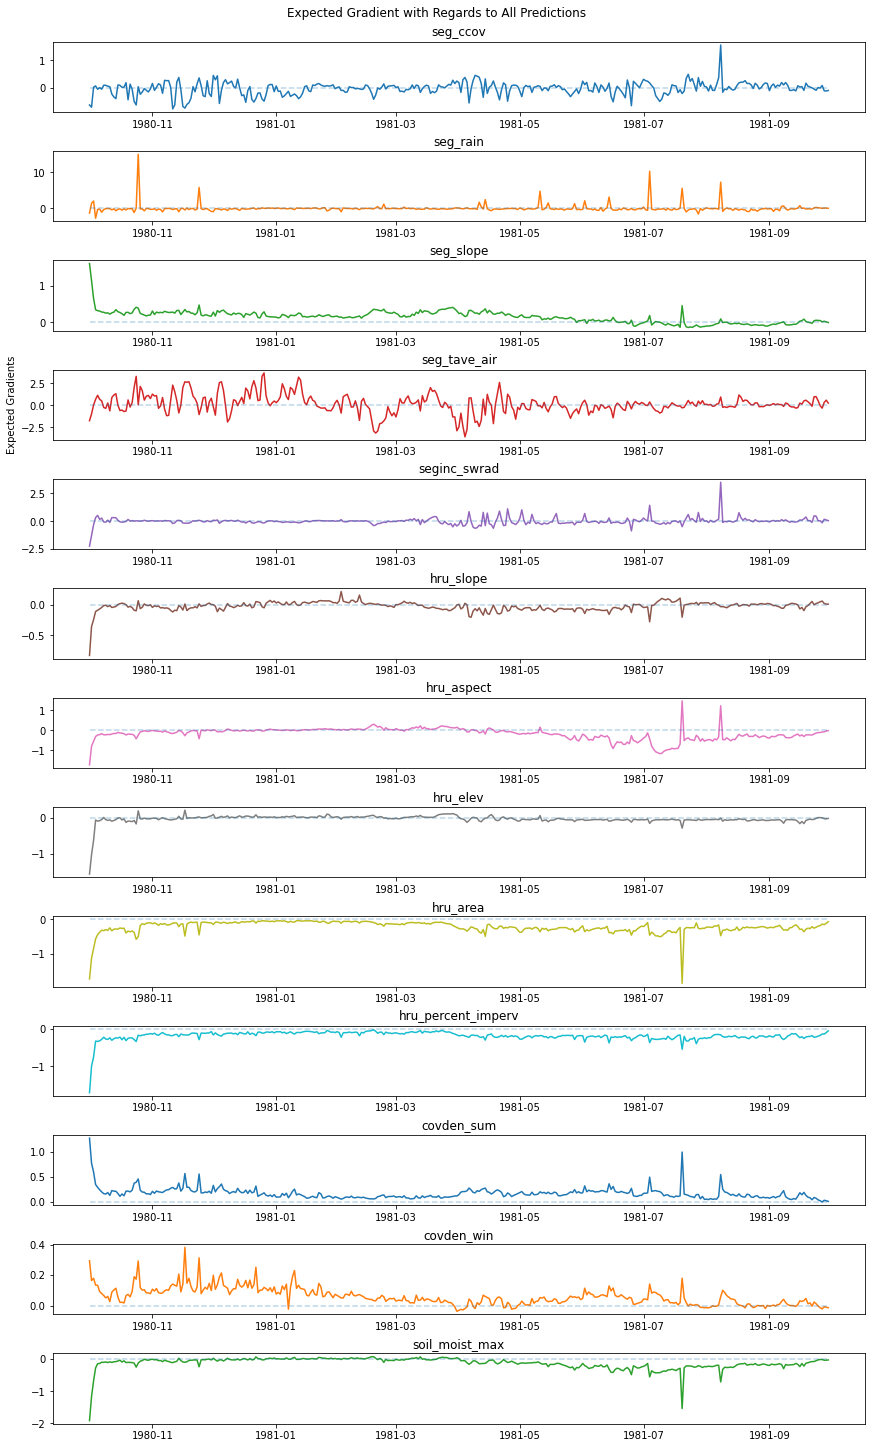

In [24]:
fig, ax = plt.subplots(len(x_vars),1,figsize=(12,20),constrained_layout=True)
fig.suptitle("Expected Gradient with Regards to All Predictions")
for i in range(len(x_vars)):
    ax[i].plot(dates,EG_vals[0, :, i], label = x_vars[i], color = "C{}".format(i))
    ax[i].set_title(x_vars[i])
    ax[i].plot(dates,np.repeat(0,len(dates)),'--',alpha=.3)
ax[3].set_ylabel('Expected Gradients')


### Get an "average" idea of influence of different variables across seasons

Here, we'll randomly select 30 sequence for each season and calculate the mean and standard deviation of EG attribution of all the inputs for the predictions within the target season.

In [45]:
### Lets try to get kind of an "average" influence of vars across the seasons

##Rough season indexes
fall = slice(0,60)
winter = slice(61,150)
spring =slice(151,240)
summer =slice(241,331)

def seasonal_egs(num_rand,season):
    ## Pull a random target sequence
    egs = []
    for i in range(num_rand):
        num_seqs = x_full.shape[0]
        rand_seq = np.random.choice(num_seqs)
        rand_seq = x_full[rand_seq]
        egs_seq = expected_gradients_tf(np.expand_dims(rand_seq,axis=0), x_full, model, n_samples=10,temporal_focus=season)
        egs.append(egs_seq)
    egs_mean = np.asarray(egs).mean(axis=0) 
    egs_std = np.asarray(egs).std(axis=0)
    return egs_mean, egs_std

fall_mean, fall_sd = seasonal_egs(30,fall)
wint_mean, wint_sd = seasonal_egs(30,winter)
spring_mean, spring_sd = seasonal_egs(30,spring)
sum_mean, sum_sd = seasonal_egs(30,summer)

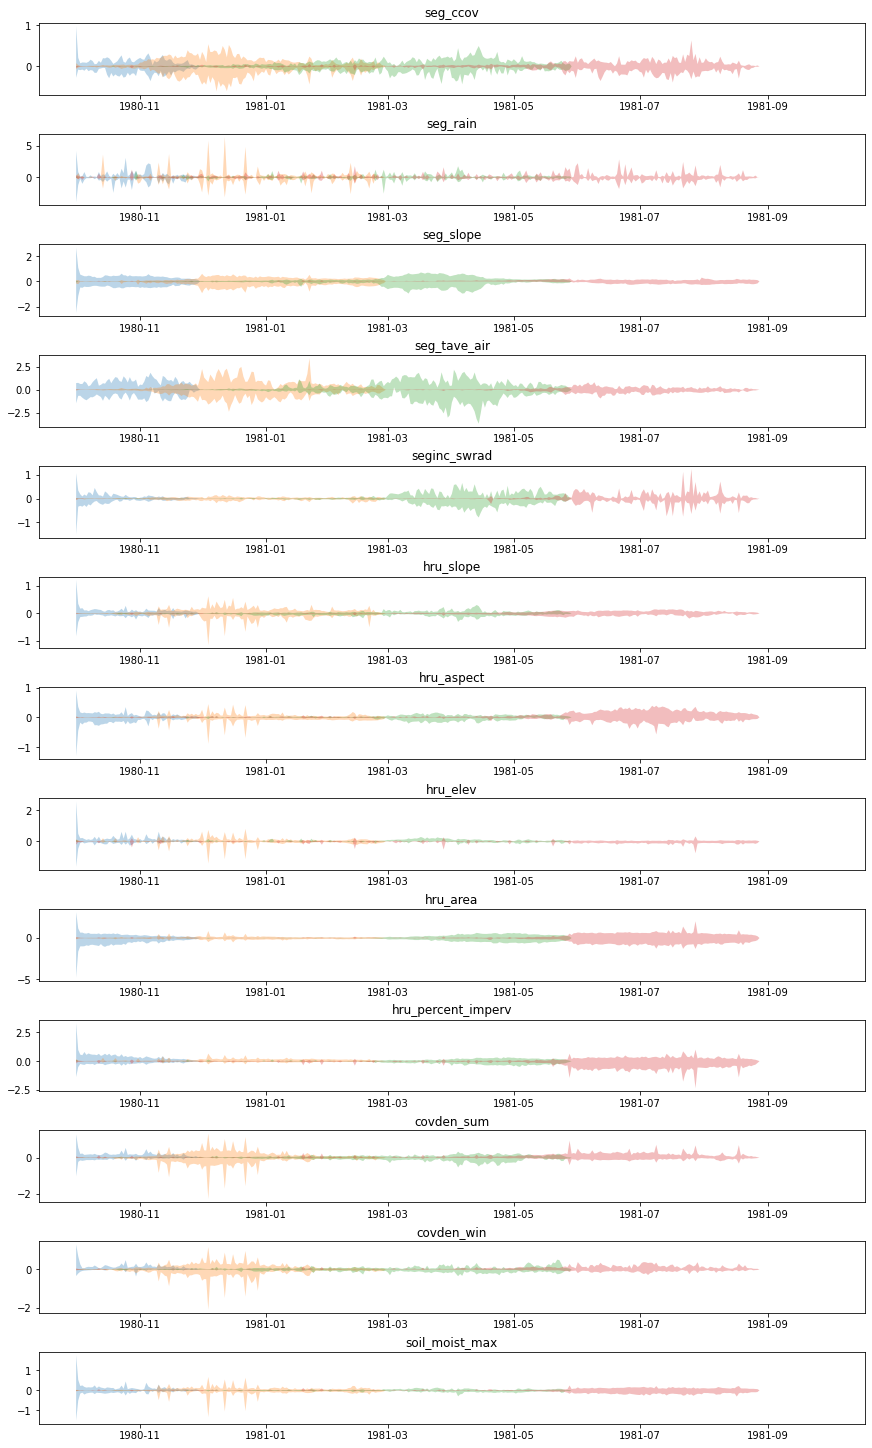

In [48]:
fig, axes = plt.subplots(len(x_vars),1,figsize=(12,20), constrained_layout=True)
for i in range(len(x_vars)):
    axes[i].fill_between(x=dates,y1=fall_mean[0,:,i]+fall_sd[0,:,i],y2=fall_mean[0,:,i]-fall_sd[0,:,i],label="Fall",alpha=.3)
    axes[i].fill_between(x=dates,y1=wint_mean[0,:,i]+wint_sd[0,:,i],y2=wint_mean[0,:,i]-wint_sd[0,:,i],label="Winter",alpha=.3)
    axes[i].fill_between(x=dates,y1=spring_mean[0,:,i]+spring_sd[0,:,i],y2=spring_mean[0,:,i]-spring_sd[0,:,i],label="Spring",alpha=.3)
    axes[i].fill_between(x=dates,y1=sum_mean[0,:,i]+sum_sd[0,:,i],y2=sum_mean[0,:,i]-sum_sd[0,:,i],label="Summer", alpha=.3)
    axes[i].set_title(x_vars[i])

Need to look at this more, but I think it got some interesting nuggets in there. Like covden_sum is important in the winter where as hru area is important all the times except the winter. (Also, actually just ran this for 10 sequences with 50 random samples per EG calculation for time, should redo with 30 and 200, but I expect it'll be similar)